## Exploratory Data Analysis

#### Basic clustering, key word extraction and conclusions on potential customer intents

In [21]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from collections import Counter
import pandas as pd

#### Loading and splitting the conversations

In [ ]:
# Read conversation file
with open('../data/conversations.txt', 'r', encoding='utf-8') as file:
    content = file.read()

# Split into individual conversations
conversations = re.split(r'(?="Agent: Thank you for calling)', content)
conversations = [conv.strip().strip('"') for conv in conversations if conv.strip()]

# Loop through each conversation
for i, conversation in enumerate(conversations):
    print(f"Conversation {i+1}:")
    print(conversation)
    print("-" * 50)

#### Basic Clustering - to reveal any vector similarity

In [9]:
# Convert conversations to vectors
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(conversations)

In [12]:
# Find optimal number of clusters using elbow method

# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Find best k (highest silhouette score)
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {best_k}")

# Cluster with optimal k
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

Optimal number of clusters: 5


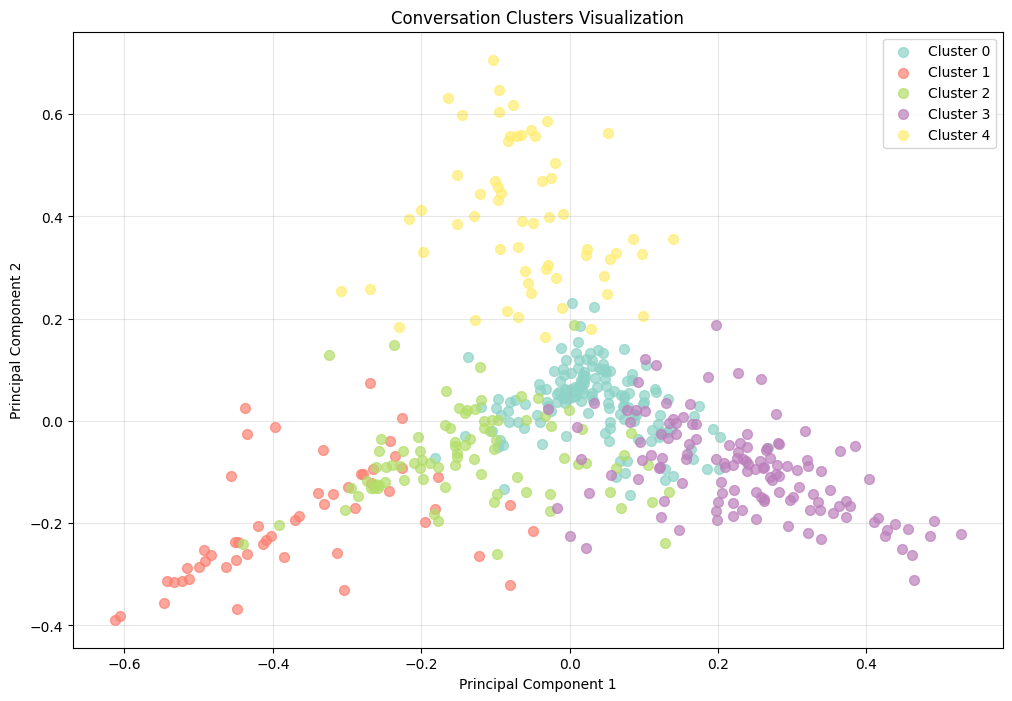

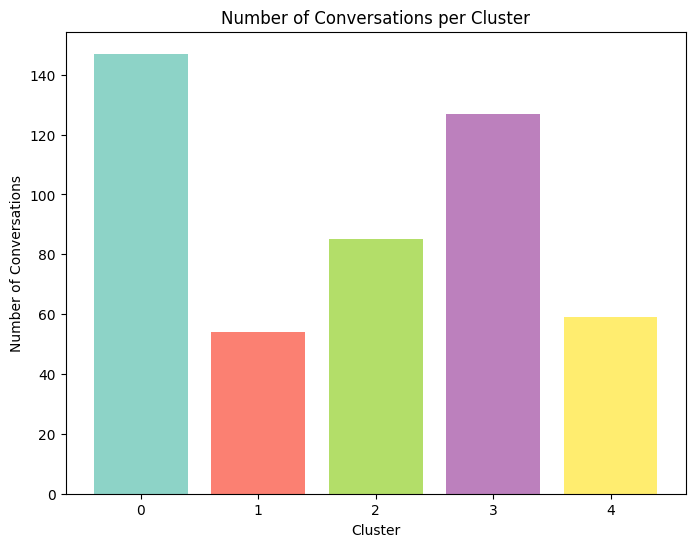

In [16]:
# Visualize clusters

# Reduce dimensions for visualization (high-dim data -> 2D)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X.toarray())

# Create visualization
plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, best_k))

for i in range(best_k):
    cluster_points = X_2d[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

plt.title('Conversation Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
        
# Show cluster sizes
plt.figure(figsize=(8, 6))
cluster_counts = [sum(clusters == i) for i in range(best_k)]
plt.bar(range(best_k), cluster_counts, color=colors[:best_k])
plt.title('Number of Conversations per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Conversations')
plt.show()

In [23]:
# cluster analysis

# keywords
def extract_keywords(text, top_n=10):
    """Extract most common words from text"""
    words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
    # Filter out common customer service words
    stop_words = {'agent', 'customer', 'thank', 'calling', 'brownbox', 'support', 'name', 'may', 'assist', 'today', 'can', 'help', 'please', 'you', 'your', 'the', 'and', 'for', 'that', 'with', 'have', 'will', 'this', 'are', 'was', 'but', 'not', 'let', 'me', 'know', 'yes', 'sure', 'okay', 'sorry', 'hear'}
    filtered_words = [word for word in words if word not in stop_words]
    return Counter(filtered_words).most_common(top_n)

cluster_analysis = {}

for cluster_id in range(best_k):
    cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
    cluster_conversations = [conversations[i] for i in cluster_indices]
    
    print(f"\n🔍 CLUSTER {cluster_id} - {len(cluster_indices)} conversations")
    print("-" * 40)
    
    # Combine all conversations in cluster for keyword analysis
    all_text = " ".join(cluster_conversations)
    top_keywords = extract_keywords(all_text, 15)
    
    print("📊 Top Keywords:")
    for word, count in top_keywords:
        print(f"  {word}: {count}")
    
    # Sample conversations analysis
    print(f"\nSample Conversations (showing 5 out of {len(cluster_indices)}):")
    for i, conv_idx in enumerate(cluster_indices[:5]):
        # Extract main customer issue/intent
        conv = conversations[conv_idx]
        # Find customer's first substantial message
        customer_lines = [line for line in conv.split('\n') if line.strip().startswith('Customer:')]
        if customer_lines:
            first_customer_msg = customer_lines[0].replace('Customer:', '').strip()[:150]
            print(f"  {i+1}. {first_customer_msg}{'...' if len(first_customer_msg) >= 150 else ''}")
    
    # Store for summary
    cluster_analysis[cluster_id] = {
        'size': len(cluster_indices),
        'top_keywords': top_keywords[:5],
        'sample_issues': []
    }
    
    print("\n" + "=" * 60)

# Summary table
print("\nCLUSTER SUMMARY TABLE")
print("=" * 80)

df_data = []
for cluster_id, data in cluster_analysis.items():
    keywords_str = ", ".join([f"{word}({count})" for word, count in data['top_keywords']])
    df_data.append({
        'Cluster': cluster_id,
        'Size': data['size'],
        'Top Keywords': keywords_str
    })

df = pd.DataFrame(df_data)
print(df.to_string(index=False))

# Cluster quality metrics
print(f"\nCLUSTER QUALITY METRICS")
print("-" * 30)
print(f"Silhouette Score: {silhouette_score(X, clusters):.3f}")
print(f"Number of clusters: {best_k}")
print(f"Total conversations: {len(conversations)}")

# Size distribution
sizes = [sum(clusters == i) for i in range(best_k)]
print(f"Cluster size std deviation: {np.std(sizes):.2f}")
print(f"Most balanced cluster size: {min(sizes)} - {max(sizes)}")


🔍 CLUSTER 0 - 147 conversations
----------------------------------------
📊 Top Keywords:
  order: 1322
  delivery: 690
  check: 609
  there: 600
  number: 578
  any: 519
  hold: 518
  our: 466
  see: 461
  sarah: 390
  how: 385
  great: 380
  anything: 380
  goodbye: 380
  email: 376

Sample Conversations (showing 5 out of 147):
  1. Hi Sarah, I am calling because I am unable to click the 'Cancel' button for my Juicer/Mixer/Grinder that I recently purchased from your website.
  2. Hi Rachel. I am calling to inquire about the delivery of my refrigerator. It was supposed to be delivered last week, but it hasn't arrived yet.
  3. Hi Alex, I'm having trouble tracking my order for a power bank. I received an email stating that my order has been shipped, but I can't seem to find a...
  4. Hi, Alex. I am trying to sign up for a water purifier on your website, but I am having trouble with the login process. I am an international customer ...
  5. Hi, Alex. I need help with a refund for my Cas

In [20]:
# Additional verification: Cross-cluster similarity check
from sklearn.metrics.pairwise import cosine_similarity

def analyze_cluster_coherence():
    """Analyze how similar conversations are within vs between clusters"""
    
    print("\n🔬 CLUSTER COHERENCE ANALYSIS")
    print("=" * 50)
    
    # Calculate intra-cluster similarity (within clusters)
    intra_similarities = []
    for cluster_id in range(best_k):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        if len(cluster_indices) > 1:
            cluster_vectors = X[cluster_indices]
            similarity_matrix = cosine_similarity(cluster_vectors)
            # Get upper triangle (avoid diagonal and duplicates)
            upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
            avg_similarity = np.mean(upper_triangle)
            intra_similarities.append(avg_similarity)
            print(f"Cluster {cluster_id}: Avg intra-cluster similarity = {avg_similarity:.3f}")
    
    # Calculate inter-cluster similarity (between clusters)
    print(f"\n📊 Inter-cluster similarities:")
    for i in range(best_k):
        for j in range(i+1, best_k):
            cluster_i_indices = [idx for idx, c in enumerate(clusters) if c == i]
            cluster_j_indices = [idx for idx, c in enumerate(clusters) if c == j]
            
            vectors_i = X[cluster_i_indices]
            vectors_j = X[cluster_j_indices]
            
            inter_similarity = cosine_similarity(vectors_i, vectors_j).mean()
            print(f"  Cluster {i} ↔ Cluster {j}: {inter_similarity:.3f}")
    
    print(f"\nOverall intra-cluster similarity: {np.mean(intra_similarities):.3f}")
    return intra_similarities

coherence_scores = analyze_cluster_coherence()


🔬 CLUSTER COHERENCE ANALYSIS
Cluster 0: Avg intra-cluster similarity = 0.612
Cluster 1: Avg intra-cluster similarity = 0.706
Cluster 2: Avg intra-cluster similarity = 0.650
Cluster 3: Avg intra-cluster similarity = 0.623
Cluster 4: Avg intra-cluster similarity = 0.739

📊 Inter-cluster similarities:
  Cluster 0 ↔ Cluster 1: 0.503
  Cluster 0 ↔ Cluster 2: 0.568
  Cluster 0 ↔ Cluster 3: 0.544
  Cluster 0 ↔ Cluster 4: 0.541
  Cluster 1 ↔ Cluster 2: 0.566
  Cluster 1 ↔ Cluster 3: 0.469
  Cluster 1 ↔ Cluster 4: 0.488
  Cluster 2 ↔ Cluster 3: 0.541
  Cluster 2 ↔ Cluster 4: 0.546
  Cluster 3 ↔ Cluster 4: 0.513

Overall intra-cluster similarity: 0.666


#### Conclusions

- Cluster 0: General Support and order issues (largest cluster and intersects all the clusters in the middle so can probably be broken down further e.g delivery issues, website problems)
- Cluster 1: Account verification
- Cluster 2: Login and Account Access (some overlap with cluster 1 and 2 on account related issues)
- Cluster 3: Returns, Exchanges and Cancellations (could split further into returns, cancellations - these would need different workflows)
- Cluster 4: Warranty and Post Purchase Support

Moderate overlap exists (based on inter-cluster similarities)